## 필요 라이브러리 불러오기

In [1]:
!pip install -q cython
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install -q -U segmentation-models-pytorch

In [79]:
import json
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as plt_path

from PIL import Image

from pathlib import Path
from pycocotools.coco import COCO

DATASET_PATH = Path('../input/synthetic-word-ocr')
img_root_path = DATASET_PATH / 'train/images'

In [80]:
import albumentations as albu
from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, Lambda
    )
from albumentations.pytorch import ToTensorV2

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
import segmentation_models_pytorch as smp

In [83]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam, SGD
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset

from torchvision.io import read_image
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [84]:
print(torch.__version__)
print(torchvision.__version__)
print(albu.__version__)

1.8.1+cu102
0.9.1+cu102
0.5.2


## 데이터셋 불러오기

In [85]:
anno_path = DATASET_PATH / 'annotation-small.json'
with open(DATASET_PATH / 'annotation-small.json', 'r') as f:
    annot_data = json.load(f)

In [86]:
annot_data

{'info': {'contributor': 'crowdAI.org',
  'about': 'Dataset for crowdAI Mapping Challenge',
  'date_created': '07/03/2018',
  'description': 'crowdAI mapping-challenge dataset',
  'url': 'https://www.crowdai.org/challenges/mapping-challenge',
  'version': '1.0',
  'year': 2018},
 'categories': [{'id': 100, 'name': 'building', 'supercategory': 'building'}],
 'images': [{'id': 232566,
   'file_name': '000000232566.jpg',
   'width': 300,
   'height': 300},
  {'id': 160847, 'file_name': '000000160847.jpg', 'width': 300, 'height': 300},
  {'id': 1457, 'file_name': '000000001457.jpg', 'width': 300, 'height': 300},
  {'id': 257667, 'file_name': '000000257667.jpg', 'width': 300, 'height': 300},
  {'id': 89311, 'file_name': '000000089311.jpg', 'width': 300, 'height': 300},
  {'id': 211570, 'file_name': '000000211570.jpg', 'width': 300, 'height': 300},
  {'id': 188843, 'file_name': '000000188843.jpg', 'width': 300, 'height': 300},
  {'id': 33121, 'file_name': '000000033121.jpg', 'width': 300, 'h

In [87]:
coco_anno = COCO(str(anno_path))
cat_ids = coco_anno.getCatIds()
cats = coco_anno.loadCats(cat_ids)
img_ids = coco_anno.getImgIds(catIds=cat_ids)

loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


## 학습 세팅

In [88]:
EPOCHS = 10
BATCH_SIZE = 16

## 함수 구현

In [89]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [90]:
def get_mask(coco, img_id, cat_ids):
    img_inf = coco.loadImgs(img_id)[0]
    img_shape = (img_inf['width'], img_inf['height'], len(cat_ids))
    ann_ids = coco_anno.getAnnIds(imgIds=img_id,
                                  catIds=cat_ids,
                                  iscrowd=None)
    anns = coco.loadAnns(ann_ids)
#     masks = np.zeros((img_inf['height'],img_inf['width'], len(cat_ids)))
#     for idx, cat_id in enumerate(cat_ids):
#         mask = np.zeros((img_inf['height'],img_inf['width']))
#         for ann in anns:
#             if cat_id == ann['category_id']:
# #                 mask = coco_anno.annToMask(ann)
#                 mask = np.maximum(mask, coco_anno.annToMask(ann))
#         masks[:, :, idx] = mask
    masks = np.zeros(img_shape)
    for idx, cat_id in enumerate(cat_ids):
        mask = np.zeros(img_shape[:2])
        for ann in anns:
            if cat_id == ann['category_id']:
                mask = np.maximum(mask, coco_anno.annToMask(ann))
        masks[:, :, idx] = mask
    return masks

In [91]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    

seed_torch()

## Pytorch 세팅

In [92]:
def get_training_augmentation(width=320, height=320):
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=height, min_width=width, always_apply=True, border_mode=0),
        albu.RandomCrop(height=height, width=width, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

In [93]:
def get_validation_augmentation(width=320, height=320):
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
#         albu.PadIfNeeded(min_height=height, min_width=width)
        albu.Resize(width, height)
    ]
    return albu.Compose(test_transform)

In [94]:
def get_transform(resize, phase='train'):
    _transforms = []
    _mean = [0.485, 0.456, 0.406]
    _std = [0.229, 0.224, 0.225]
    if phase == 'train':
        _transforms.append(Resize(resize, resize))
        _transforms.append(HorizontalFlip(p=0.5))
        _transforms.append(VerticalFlip(p=0.5))
#         for t in [
#             RandomResizedCrop(resize, resize),
#             Transpose(p=0.5),
#             HorizontalFlip(p=0.5),
#             VerticalFlip(p=0.5),
#             ShiftScaleRotate(p=0.5)]:
#             _transforms.append(t)
        ,
    else:
        _transforms.append(Resize(resize, resize))
    # 
    _transforms.append(Normalize(
                mean=_mean,
                std=_std,
            ))
    _transforms.append(ToTensorV2())
    return Compose(_transforms)

In [95]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [96]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        Lambda(image=preprocessing_fn),
        Lambda(image=to_tensor, mask=to_tensor)
    ]
    return Compose(_transform)

In [97]:
class SegDataset(Dataset):
    def __init__(self, root_dir, img_ids, cat_ids, coco_api, transforms=None, preprocessing=None):
        self.root_dir = root_dir
        self.img_ids = img_ids
        self.cat_ids = cat_ids
        self.coco_api = coco_api
        self.transforms = transforms
        self.preprocessing = preprocessing
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_inf = self.coco_api.loadImgs(img_id)[0]
        file_name = img_inf['file_name']
        file_path = self.root_dir / file_name
        img = Image.open(file_path).convert('RGB')
        mask = get_mask(self.coco_api, img_id, self.cat_ids)
        
        if self.transforms:
            augmented = self.transforms(image=np.array(img), mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        if self.preprocessing:
            augmented = self.preprocessing(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        return img, mask
    
    def __len__(self):
        return len(self.img_ids)

In [98]:
train_img_ids, valid_img_ids = train_test_split(img_ids, test_size=0.1, random_state=42)
valid_img_ids, test_img_ids = train_test_split(valid_img_ids, test_size=0.5, random_state=42)
print(len(train_img_ids), len(valid_img_ids), len(test_img_ids))

7529 418 419


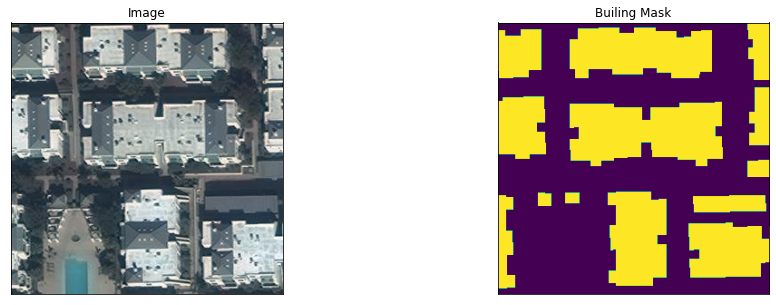

In [99]:
sample_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=train_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno)
image, mask = sample_dataset[8] # get some sample
visualize(
    image=image, 
    builing_mask=mask.squeeze(),
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


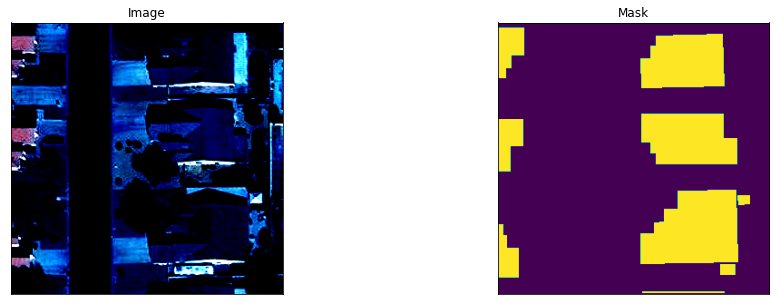

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


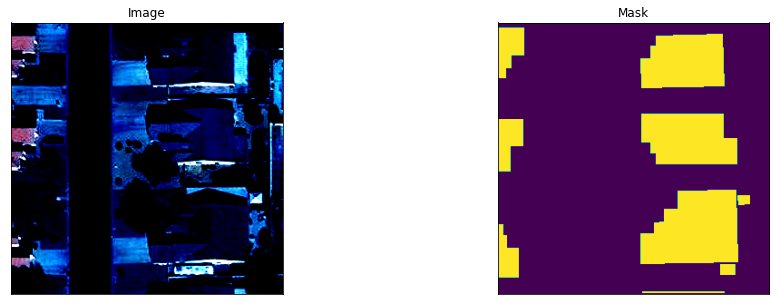

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


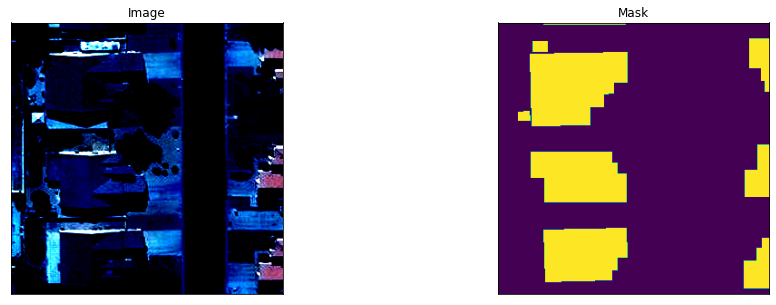

In [100]:
augmented_dataset = SegDataset(root_dir=img_root_path,
                               img_ids=train_img_ids,
                               cat_ids=cat_ids,
                               coco_api=coco_anno,
                               transforms=get_transform(resize=300, phase='train'))
for i in range(3):
    image, mask = augmented_dataset[4]
    visualize(image=image.numpy().transpose(1, 2, 0), mask=mask.squeeze())

## Pytorch segmentation model

In [101]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['building']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [102]:
_preprocessing = get_preprocessing(preprocessing_fn)

train_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=train_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           transforms=get_training_augmentation(288, 288),
                           preprocessing=_preprocessing)
valid_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=valid_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           transforms=get_validation_augmentation(288, 288),
                           preprocessing=_preprocessing)

In [103]:
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4,
                          pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4,
                          pin_memory=True,
                          drop_last=True)

In [104]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

## 모델 학습

In [105]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [106]:
max_score = 0


#train accurascy, train loss, val_accuracy, val_loss をグラフ化できるように設定．
x_epoch_data = []
train_dice_loss = []
train_iou_score = []
valid_dice_loss = []
valid_iou_score = []

for i in range(EPOCHS):

    print(f'\nEpoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    x_epoch_data.append(i)
    train_dice_loss.append(train_logs['dice_loss'])
    train_iou_score.append(train_logs['iou_score'])
    valid_dice_loss.append(valid_logs['dice_loss'])
    valid_iou_score.append(valid_logs['iou_score'])

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_Unet_resnet50.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 1
valid: 100%|██████████| 26/26 [00:04<00:00,  5.85it/s, dice_loss - 0.2307, iou_score - 0.7107]
Model saved!

Epoch: 2
valid: 100%|██████████| 26/26 [00:03<00:00,  6.67it/s, dice_loss - 0.1649, iou_score - 0.7461]
Model saved!

Epoch: 3
valid: 100%|██████████| 26/26 [00:03<00:00,  6.62it/s, dice_loss - 0.1476, iou_score - 0.7591]
Model saved!

Epoch: 4
valid: 100%|██████████| 26/26 [00:03<00:00,  6.52it/s, dice_loss - 0.1348, iou_score - 0.7708]
Model saved!

Epoch: 5
valid: 100%|██████████| 26/26 [00:04<00:00,  6.35it/s, dice_loss - 0.1321, iou_score - 0.7719]
Model saved!

Epoch: 6
valid: 100%|██████████| 26/26 [00:03<00:00,  6.62it/s, dice_loss - 0.1301, iou_score - 0.7737]
Model saved!

Epoch: 7
valid: 100%|██████████| 26/26 [00:03<00:00,  6.55it/s, dice_loss - 0.128, iou_score - 0.7762] 
Model saved!

Epoch: 8
valid: 100%|██████████| 26/26 [00:04<00:00,  6.44it/s, dice_loss - 0.1212, iou_score - 0.7866]
Model saved!

Epoch: 9
valid: 100%|██████████| 26/26 [00:03<00:00,  6

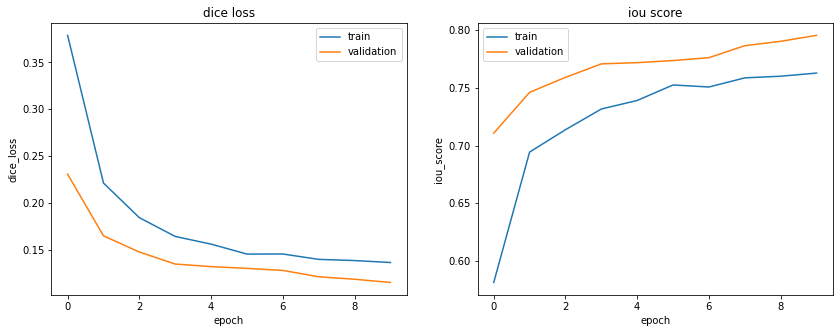

In [107]:
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(1, 2, 1)
line1, = ax1.plot(x_epoch_data,train_dice_loss,label='train') 
line2, = ax1.plot(x_epoch_data,valid_dice_loss,label='validation')
ax1.set_title("dice loss")
ax1.set_xlabel('epoch')
ax1.set_ylabel('dice_loss')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 2, 2)
line1, = ax2.plot(x_epoch_data,train_iou_score,label='train')
line2, = ax2.plot(x_epoch_data,valid_iou_score,label='validation') 
ax2.set_title("iou score")
ax2.set_xlabel('epoch')
ax2.set_ylabel('iou_score')
ax2.legend(loc='upper left')

plt.show()

In [108]:
best_model = torch.load('./best_model_Unet_resnet50.pth')

In [109]:
test_dataset = SegDataset(root_dir=img_root_path,
                           img_ids=test_img_ids,
                           cat_ids=cat_ids,
                           coco_api=coco_anno,
                           transforms=get_validation_augmentation(288, 288),
                           preprocessing=_preprocessing)
test_dataloader = DataLoader(test_dataset)

In [110]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 419/419 [00:10<00:00, 38.35it/s, dice_loss - 0.1402, iou_score - 0.7746]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


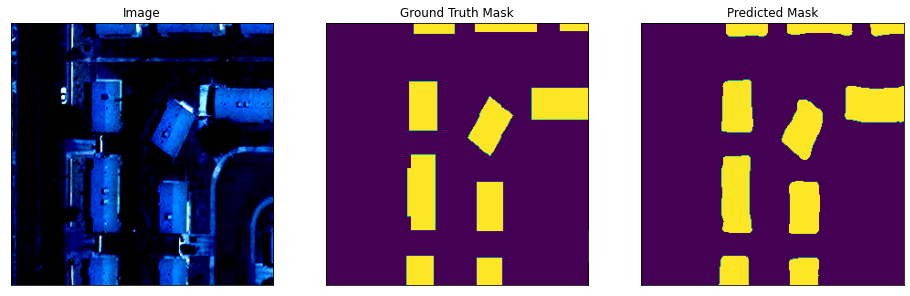

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


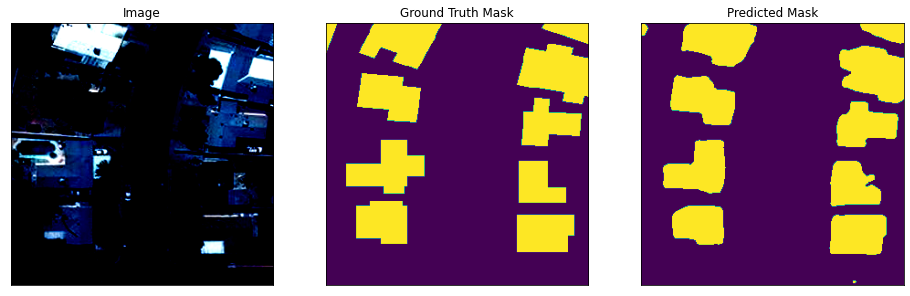

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


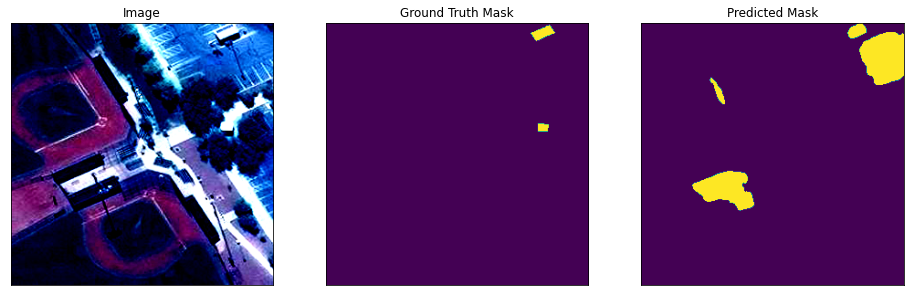

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


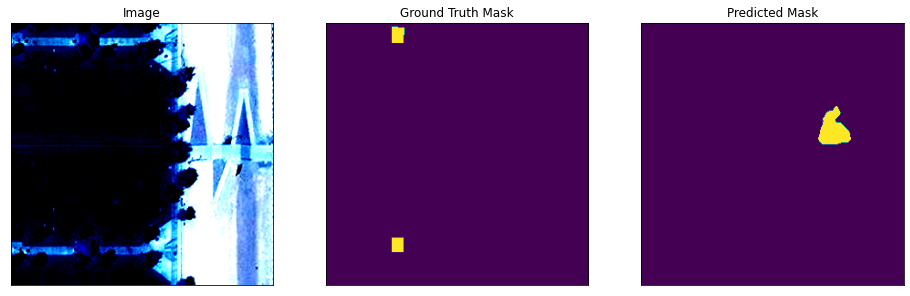

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


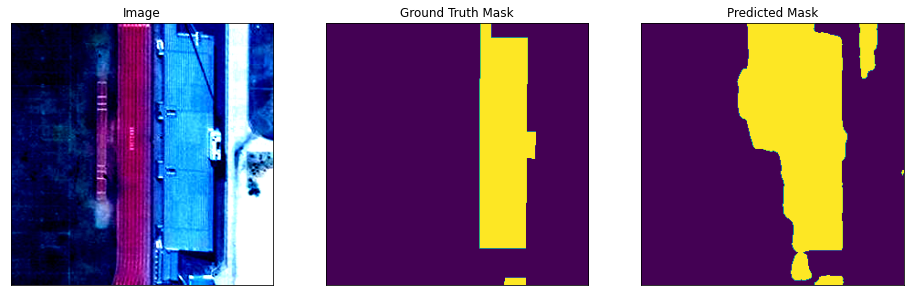

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


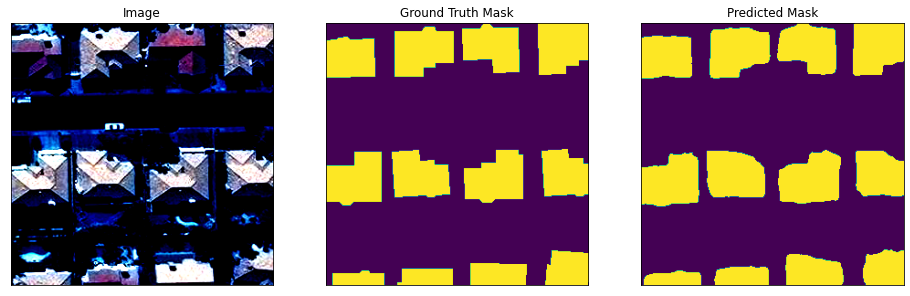

In [111]:
for i in range(6):
    n = np.random.choice(len(test_dataset))
    image, gt_mask = test_dataset[n]

    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(
        image=image.transpose(1, 2, 0), 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )